# Spatial Visualizations and Analysis in Python with Folium

There are several clear advantages of visualizing spatial data with maps:
1. Being able to obtain a visual representation of the location of the data points, thus enabling us to relate the data points that we have to the real world easily.
2. Make it possible to us to generate geographical insights from the data that we have.

Using maps instead of other forms of charting allows us to highlight trends, uncover patterns, and reveal realities not visible before when it comes to spatial data. It also helps us in gaining clarity about the data, more than just simplifying the data itself.

## Folium
Folium is a Python Library that can allow us to visualize spatial data in an interactive manner. The library is highly intuitive to use, and it offers a high degree of interactivity with a low learning curve. Best of all, it is all **Open Source** 

## Installation

*conda install folium -c conda-forge*

# Example: Police Department Incident Reports

## Dataset
We will use the **Police Department Incident Reports: 2018 to Present** from *SF OpenData*. 

https://data.sfgov.org/Public-Safety/Map-of-Police-Department-Incident-Reports-2018-to-/jq29-s5wp

This dataset includes police incident reports filed by officers and by individuals through self-service online reporting for non-emergency cases. Reports included are those for incidents that occurred starting January 1, 2018 onward and have been approved by a supervising officer. 

### Data fields
**Report types**

Reports can come from one of three sources. These are discernable through the “Report Type Description” and “Report Type Code” field:
1. Initial: The first report filed for the incident
2. Vehicle: A special incident report related to stolen and/or recovered vehicles
3. Coplogic: Filed online by an individual

Each report can either be an initial one or a supplement. These can also be discerned through the “Report Type Description” field:
1. Initial
2. Initial Supplement
3. Vehicle Initial
4. Vehicle Supplement
5. Coplogic Initial
6. Coplogic Supplement

**Supplemental Reports**

Supplemental reports are issued to provide additional incident information or to clarify a mistake in the initial report. For example, a supplemental report may be issued to show an arrest was made, a missing person was found or to provide additional details of property taken in a theft.


**Relationship of incident codes to reports**

Incidents can have one or many associated Incident Codes. For example, an officer may have a warrant for an arrest and while making the arrest discovers narcotics in the individual’s possession. The officer would record an incident code for the warrant as well as the discovery of narcotics.

For this reason, Row ID is unique across rows, but Incident ID and Incident Number are unique to an incident and can be duplicated within the dataset. Put another way, the dataset represents a flattened representation of these 1 to
many relationships.

**Mapping coordinates**

Coordinates are provided within the dataset where feasible. Coordinates could be missing for the following reasons:
1. Invalid addresses - addresses submitted by officers pass through validation, however, the online submission does not validate addresses on entry. 
2. Addresses for incidents outside of SF - some cases are referred from outside SFPD districts, these will be marked as Out of SF in the Police District column and not have associated geographic information.


## Importing and Preprocessing Data
We start by importing the libraries that we will be using, *Pandas* and *Folium*, importing all the files that we will be using, dropping columns we will not be using.



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import folium

df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Police_Department_Incident_Reports__2018_to_Present.csv')

In [0]:
df.columns

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude',
       'point'],
      dtype='object')

In [0]:
df = df[['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year','Incident Day of Week','Incident ID','Incident Category', 'Incident Description', 'Police District', 'Latitude', 'Longitude']]

In [0]:
df.head()

Incident Datetime Incident Date  ...   Latitude   Longitude
0  2018/07/18 01:30:00 PM    2018/07/18  ...        NaN         NaN
1  2019/08/05 03:29:00 AM    2019/08/05  ...        NaN         NaN
2  2019/04/08 05:25:00 AM    2019/04/08  ...        NaN         NaN
3  2019/06/05 02:00:00 PM    2019/06/05  ...  37.782685 -122.422464
4  2019/08/05 05:22:00 AM    2019/08/05  ...        NaN         NaN

[5 rows x 11 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253883 entries, 0 to 253882
Data columns (total 11 columns):
Incident Datetime       253883 non-null object
Incident Date           253883 non-null object
Incident Time           253883 non-null object
Incident Year           253883 non-null int64
Incident Day of Week    253883 non-null object
Incident ID             253883 non-null int64
Incident Category       253864 non-null object
Incident Description    253883 non-null object
Police District         253883 non-null object
Latitude                239130 non-null float64
Longitude               239130 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 21.3+ MB


We build new columns with the month and the hour of the incident for later use

In [0]:
df['Incident Datetime'] = pd.to_datetime(df['Incident Datetime'], format='%Y/%m/%d %I:%M:%S %p')
df['month'] = df['Incident Datetime'].apply(lambda x: x.month)
df['hour'] = df['Incident Datetime'].apply(lambda x: x.hour)

df.head()

Incident Datetime Incident Date Incident Time  ...   Longitude month  hour
0 2018-07-18 13:30:00    2018/07/18         13:30  ...         NaN     7    13
1 2019-08-05 03:29:00    2019/08/05         03:29  ...         NaN     8     3
2 2019-04-08 05:25:00    2019/04/08         05:25  ...         NaN     4     5
3 2019-06-05 14:00:00    2019/06/05         14:00  ... -122.422464     6    14
4 2019-08-05 05:22:00    2019/08/05         05:22  ...         NaN     8     5

[5 rows x 13 columns]

We will remove duplacate incident IDs, keeping only the first

In [0]:
df.sort_values("Incident ID", inplace = True) 
df.drop_duplicates(subset ="Incident ID", keep = 'first', inplace = True)
df.reset_index(drop=True, inplace=True)
df.head()

Incident Datetime Incident Date Incident Time  ...   Longitude month  hour
0 2018-01-01 00:10:00    2018/01/01         00:10  ...         NaN     1     0
1 2018-01-01 00:55:00    2018/01/01         00:55  ... -122.405828     1     0
2 2018-01-01 00:40:00    2018/01/01         00:40  ... -122.408227     1     0
3 2018-01-01 00:57:00    2018/01/01         00:57  ... -122.410765     1     0
4 2018-01-01 00:32:00    2018/01/01         00:32  ... -122.429178     1     0

[5 rows x 13 columns]

We remove rows without latitude or longitude set

In [0]:
import numpy as np
df = df[np.isfinite(df['Latitude'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192648 entries, 1 to 208474
Data columns (total 13 columns):
Incident Datetime       192648 non-null datetime64[ns]
Incident Date           192648 non-null object
Incident Time           192648 non-null object
Incident Year           192648 non-null int64
Incident Day of Week    192648 non-null object
Incident ID             192648 non-null int64
Incident Category       192635 non-null object
Incident Description    192648 non-null object
Police District         192648 non-null object
Latitude                192648 non-null float64
Longitude               192648 non-null float64
month                   192648 non-null int64
hour                    192648 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 20.6+ MB


Finally, we remove incidents out of San Francisco

In [0]:
df = df[df['Police District'] != 'Out of SF']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192648 entries, 1 to 208474
Data columns (total 13 columns):
Incident Datetime       192648 non-null datetime64[ns]
Incident Date           192648 non-null object
Incident Time           192648 non-null object
Incident Year           192648 non-null int64
Incident Day of Week    192648 non-null object
Incident ID             192648 non-null int64
Incident Category       192635 non-null object
Incident Description    192648 non-null object
Police District         192648 non-null object
Latitude                192648 non-null float64
Longitude               192648 non-null float64
month                   192648 non-null int64
hour                    192648 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 20.6+ MB


## Visualizing Spatial Data with Folium
There are a couple of things to note before we work with visualizations using Folium:
1. Maps are defined as a folium.Map object, and we can add other folium objects on top of the folium.Map to improve/add to the map rendered
2. Folium allows the users to select different map projections. We will be using the Spherical Mercator projection since we are visualizing a relatively small area size, and it is a more commonly used projection.
3. We can use different map tiles for the map rendered by Folium, such as from OpenStreetMap, MapBox (Using tiles from MapBox require you to put the API Key that you have for MapBox licence as one of the arguments), and several other tiles:
* “OpenStreetMap”

* “Mapbox Bright” (Limited levels of zoom for free tiles)

* “Mapbox Control Room” (Limited levels of zoom for free tiles)

* “Stamen” (Terrain, Toner, and Watercolor)

* “Cloudmade” (Must pass API key)

* “Mapbox” (Must pass API key)

* “CartoDB” (positron and dark_matter)


## folium.Map()

This class method will always be the first thing that you execute when working with Folium. The purpose of this function is to generate the default map object that will be rendered by your notebook, and the object that we will be building on top of for our visualizations.
We can start with our map visualization by defining the default map object.

In [0]:
def generateBaseMap(default_location=[37.76, -122.45], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles='Stamen Terrain')
    return base_map

There are several parameters within this class function for example:
1. location, this parameter basically define the default location that will be shown by the map as the center location.
2. zoom_start, which defines the default magnification level of the map
3. control_scale, enables/disables the map scale for a given zoom level. This is something that sometimes can be handy to have for us to get an idea of the scale of the geographical area that we are looking at.

There are also many other parameters that can be set within this class method, which you can read up from here: https://python-visualization.github.io/folium/py-modindex.html

In [0]:
base_map = generateBaseMap()
base_map.save("/content/gdrive/My Drive/Colab Notebooks/base_crime_map.html")
base_map

## Markers

Markers allow to add info to the map

In [0]:
base_map = generateBaseMap()
subset_data = df[0:1000]

for each in subset_data.iterrows():
    hint = each[1]['Incident Description']+"\n("+each[1]['Incident Category']+")"
    if (each[1]['Incident Description']=='Terrorist Threats'):
      icon=folium.Icon(color='red')
    else:
      icon=folium.Icon(color='green', icon='map-marker')
    base_map.add_child(folium.Marker(
        location = [each[1]['Latitude'],each[1]['Longitude']], 
        popup=hint,
        icon = icon))

display(base_map)

## MarkerClusters

In [0]:
%%time

base_map = generateBaseMap()

from folium.plugins import MarkerCluster
# create a marker cluseter
mc = MarkerCluster()
 
# add a marker for every record in the filtered data, use a clustered view
for each in df[0:1000].iterrows():
    hint = each[1]['Incident Description']+"\n("+each[1]['Incident Category']+")"
    if (each[1]['Incident Description']=='Terrorist Threats'):
      icon=folium.Icon(color='red')
    else:
      icon=folium.Icon(color='green', icon='map-marker')
    mc.add_child(folium.Marker(
        location = [each[1]['Latitude'],each[1]['Longitude']],
        popup=hint,
        icon = icon))

base_map.add_child(mc)
display(base_map)

CPU times: user 1.95 s, sys: 28.4 ms, total: 1.98 s
Wall time: 1.97 s


## FastMarkerCluster

**FastMarkerCluster** is not as flexible as MarkerCluster but, like the name suggests, it is faster.

In [0]:
%%time

from folium.plugins import FastMarkerCluster

#FastMarkerCluster are created using a list of lists with latitude and longitude values
data = df[0:1000]
data = data[['Latitude', 'Longitude']].values.tolist()

fast_map = generateBaseMap()

callback = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "map-marker", markerColor: "red"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""                             
fast_map.add_child(FastMarkerCluster(data, callback=callback))
display(fast_map)

CPU times: user 27.8 ms, sys: 982 µs, total: 28.8 ms
Wall time: 29.5 ms


## HeatMap()

We will be visualizing the crime data using a class method **Heatmap()**. This class function can be used to overlay a heat map over the map object that we have created previously.

Parameters
* **data** (list of points of the form [lat, lng] or [lat, lng, weight]) – The points you want to plot. You can also provide a numpy.array of shape (n,2) or (n,3).

* **name** (string, default None) – The name of the Layer, as it will appear in LayerControls.

* **min_opacity** (default 1.) – The minimum opacity the heat will start at.

* **max_zoom** (default 18) – Zoom level where the points reach maximum intensity (as intensity scales with zoom), equals maxZoom of the map by default

* **max_val** (float, default 1.) – Maximum point intensity

* **radius** (int, default 25) – Radius of each “point” of the heatmap

* **blur** (int, default 15) – Amount of blur

* **gradient** (dict, default None) – Color gradient config. e.g. {0.4: ‘blue’, 0.65: ‘lime’, 1: ‘red’}

* **overlay** (bool, default True) – Adds the layer as an optional overlay (True) or the base layer (False).

* **control** (bool, default True) – Whether the Layer will be included in LayerControls.

* **show** (bool, default True) – Whether the layer will be shown on opening (only for overlays).

In [0]:
from folium.plugins import HeatMap

df_copy = df.copy()
df_copy['count'] = 1
base_map = generateBaseMap()
data_as_list = df_copy[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data_as_list, radius=8, max_zoom=13).add_to(base_map)
base_map.save('/content/gdrive/My Drive/Colab Notebooks/crime-heatmap.html')
print(df_copy.info())

display(base_map)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192648 entries, 1 to 208474
Data columns (total 14 columns):
Incident Datetime       192648 non-null datetime64[ns]
Incident Date           192648 non-null object
Incident Time           192648 non-null object
Incident Year           192648 non-null int64
Incident Day of Week    192648 non-null object
Incident ID             192648 non-null int64
Incident Category       192635 non-null object
Incident Description    192648 non-null object
Police District         192648 non-null object
Latitude                192648 non-null float64
Longitude               192648 non-null float64
month                   192648 non-null int64
hour                    192648 non-null int64
count                   192648 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(6)
memory usage: 22.0+ MB
None


In [0]:
base_map.add_child(folium.ClickForMarker(popup='Hot areas'))
base_map.save('/content/gdrive/My Drive/Colab Notebooks/crime-heatmap.html')
base_map

After adding the folium.ClickForMarker() object to the map object that we have created, we can click on locations within the map itself to add markers. 

## HeatMapWithTime()

We can also animate our heat maps to change the data being shown on it based on certain dimension(s) (i.e. hour, month) using a class method called HeatMapWithTime(). This method will allow us to animate the heat map that is rendered by our notebook.
First, we need to create a list containing the list of values that we wish to plot, grouped by the dimension that we want to use (in this example we will be using hour as the dimension).

The loc medthod of dataframes selects rows and columns according to the given condition. In this case, we will select the columns *Latitude*, *Longitude* and *count*

In [0]:
df_hour_list = []
for hour in df_copy['hour'].sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy['hour'] == hour, ['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
df_hour_list[0][:10] #The first 10 records for hour 0

[[37.70802018416812, -122.41249676853344, 1.0],
 [37.70805761187209, -122.44198634816915, 1.0],
 [37.70831126504184, -122.42008306742426, 2.0],
 [37.708328120042246, -122.44984660557805, 1.0],
 [37.70835433601625, -122.45592824529075, 1.0],
 [37.70858376779393, -122.44483941360352, 2.0],
 [37.70866203203559, -122.46927073577235, 2.0],
 [37.70867486585139, -122.4704011412784, 1.0],
 [37.70880633652071, -122.45266472219632, 3.0],
 [37.708870632477726, -122.42928919905545, 1.0]]

After we generated the data that we will use for the HeatMapWithTime class method, we can call the method and add it to our map.

In [0]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('/content/gdrive/My Drive/Colab Notebooks/crime-heatmap-with-time.html')

Looking at the result above, it can be seen that throughout the day, there is almost always a crime in the north-east area of San Francisco. Furthermore most of the crimes in this area are reported between 10 and 11 pm

## Choropleth map

According to Wikipedia, a choropleth map (from Greek χώρο (“area/region”) + πλήθος (“multitude”)) is a thematic map in which areas are shaded or patterned in proportion to the measurement of the statistical variable being displayed on the map, such as population density or per-capita income.

To create a choropleth, we need a geojson file to create the areas/boundaries that match the San Francisco police districts in the data file. You can easily find one with a Google search. You can also do the hard work and create one by using the online tool at http://geojson.io

In [0]:
# definition of the boundaries in the map
district_geo = r'/content/gdrive/My Drive/Colab Notebooks/sf_districts.geojson'
  
# calculating total number of incidents per district
crimedata2 = pd.DataFrame(df['Police District'].value_counts().astype(float))
crimedata2.to_json('/content/gdrive/My Drive/Colab Notebooks/crimeagg.json')
crimedata2 = crimedata2.reset_index()
crimedata2.columns = ['District', 'Number']
crimedata2['District'] = crimedata2['District'].str.upper() #Just because this info is uppercased in the geojson file
crimedata2
  

District   Number
0     CENTRAL  31859.0
1    NORTHERN  26966.0
2     MISSION  26038.0
3    SOUTHERN  24869.0
4  TENDERLOIN  18472.0
5     BAYVIEW  16331.0
6   INGLESIDE  13927.0
7     TARAVAL  13751.0
8    RICHMOND  11075.0
9        PARK   9360.0

In [0]:
# creation of the choropleth
map1 = generateBaseMap()
folium.Choropleth(geo_data = district_geo, 
              #data_out = '/content/gdrive/My Drive/Colab Notebooks/crimeagg.json', 
              data = crimedata2,
              columns = ['District', 'Number'],
              key_on = 'feature.properties.district',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Number of incidents per district').add_to(map1)
               
display(map1)

FileNotFoundError: ignored

# References

1. https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf
2. https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/
3. Police Department Incident Reports: 2018 to Present. Documentation: https://bit.ly/2x7Ta2P
4. https://data.sfgov.org
5. Alberto Cairo. The Functional Art: An Introduction to Information Graphics and Visualization. New Riders Publishing. 2012.

# Hands on New York City Taxi Trip data

## Dataset
We will be using the data from the New York City Taxi Trip Duration DataSet that can be obtained from Kaggle at: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

### Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

## Example analysis question
The city is planning to build taxi stops, locations throughout the city where people can get picked up/dropped off by cabs and wait for cabs to pick them up. This initiative is aiming to:
1. Making it easier and safer for the citizens of the city to get a cab especially during night time
2. Allowing taxi cab drivers to know where to go when they want to find riders
Allowing potential riders to have a point where they can go to when they are looking for taxis.

Your task is to suggest the best locations for these taxi stops, and also to generate insights about the pattern of rides amount throughout the day across the city.

# Solution New York City Taxi Trip

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

In [0]:
df[-5:]

id  vendor_id  ... store_and_fwd_flag trip_duration
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[5 rows x 11 columns]

In [0]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df.rename({'pickup_longitude': 'plog', 'pickup_latitude': 'plat', 'dropoff_longitude': 'dlog', 'dropoff_latitude': 'dlat',
               'trip_duration': 'duration'},axis = 1, inplace = True)

In [0]:
df.head(5)

id  vendor_id  ... store_and_fwd_flag duration
0  id2875421          2  ...                  N      455
1  id2377394          1  ...                  N      663
2  id3858529          2  ...                  N     2124
3  id3504673          2  ...                  N      429
4  id2181028          2  ...                  N      435

[5 rows x 11 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
plog                  1458644 non-null float64
plat                  1458644 non-null float64
dlog                  1458644 non-null float64
dlat                  1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
duration              1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 133.5+ MB


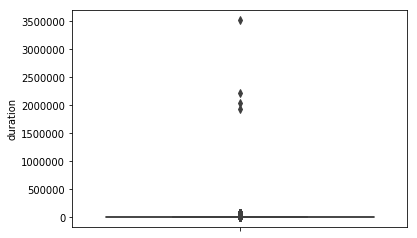

In [0]:
import seaborn as sns
sns.boxplot(y = df.duration)

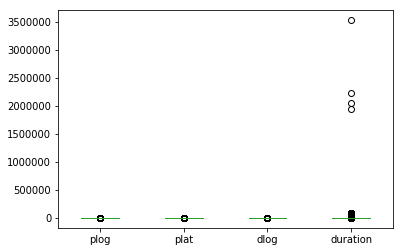

In [0]:
import matplotlib.pyplot as plt
df[['plog', 'plat', 'dlog', 'duration']][df.duration >100].plot(kind='box')

In [0]:
def generateBaseMap(default_location=[40.730610, -73.935242], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles='Stamen Terrain')
    return base_map

In [0]:
base_map = generateBaseMap()
subset_data = df[0:500]


for ii in subset_data.iterrows():
  start = 'start time: ' + str(ii[1]['pickup_datetime'])
  endtime = 'end:'+ str(ii[1]['dropoff_datetime'])
  if ii[1]['pickup_datetime']:
    icon=folium.Icon(color='green')
    base_map.add_child(folium.Marker(
        location = [ii[1]['plat'],ii[1]['plog']], 
        popup=start,
        icon = icon))
  if ii[1]['dropoff_datetime']:
    icon=folium.Icon(color='red')
    base_map.add_child(folium.Marker(
          location = [ii[1]['dlat'],ii[1]['dlog']], 
          popup=endtime,
          icon = icon))
  base_map.add_child(folium.PolyLine(
          locations = [[ii[1]['plat'], ii[1]['plog']],
                     [ii[1]['dlat'], ii[1]['dlog']]], 
          ))
  
display(base_map)

In [0]:

for ii in subset_data.iterrows():
  start = 'start time: ' + str(ii[1]['pickup_datetime'])
  endtime = 'end:'+ str(ii[1]['dropoff_datetime'])
  if ii[1]['pickup_datetime']:
    icon=folium.Icon(color='green')
    base_map.add_child(folium.Marker(
        location = [ii[1]['plat'],ii[1]['plog']], 
        popup=start,
        icon = icon))
  elif ii[1]['dropoff_datetime']:
    icon=folium.Icon(color='red')
    base_map.add_child(folium.Marker(
          location = [ii[1]['dlat'],ii[1]['dlog']], 
          popup=endtime,
          icon = icon))
  base_map.add_child(folium.PolyLine(
          locations = [[ii[1]['plat'], ii[1]['plog']],
                     [ii[1]['dlat'], ii[1]['dlog']]], 
          ))
  
display(base_map)

start time
(0, id                              id2875421
vendor_id                               2
pickup_datetime       2016-03-14 17:24:55
dropoff_datetime      2016-03-14 17:32:30
passenger_count                         1
plog                             -73.9822
plat                              40.7679
dlog                             -73.9646
dlat                              40.7656
store_and_fwd_flag                      N
duration                              455
Name: 0, dtype: object)
start time
(1, id                              id2377394
vendor_id                               1
pickup_datetime       2016-06-12 00:43:35
dropoff_datetime      2016-06-12 00:54:38
passenger_count                         1
plog                             -73.9804
plat                              40.7386
dlog                             -73.9995
dlat                              40.7312
store_and_fwd_flag                      N
duration                              663
Name: 1, dtype: object

In [0]:
from folium.plugins import HeatMap

df_copy = df[:1000].copy()
df_copy['count'] = 1
base_map = generateBaseMap()
data_as_list = df_copy[['plog', 'plat', 'count']].groupby(['plog', 'plat']).sum().reset_index().values.tolist()
HeatMap(data=data_as_list, radius=8, max_zoom=13).add_to(base_map)
base_map.save('/content/gdrive/My Drive/Colab Notebooks/crime-heatmap.html')
print(df_copy.info())

display(base_map)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
id                    1000 non-null object
vendor_id             1000 non-null int64
pickup_datetime       1000 non-null datetime64[ns]
dropoff_datetime      1000 non-null datetime64[ns]
passenger_count       1000 non-null int64
plog                  1000 non-null float64
plat                  1000 non-null float64
dlog                  1000 non-null float64
dlat                  1000 non-null float64
store_and_fwd_flag    1000 non-null object
duration              1000 non-null int64
count                 1000 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(2)
memory usage: 101.6+ KB
None


# Hands on Accidents managed by the local police in the city of Barcelona

## Dataset
We will be using the data containing a list of accidents handled by the local police in the city of Barcelona. Incorporates the number of injuries by severity, the number of vehicles and the point of impact. The coordinates are measured with the Universal Transverse Mercator (UTM) reference system and with the geographic system (longitude and latitude).

The dataset is available at: https://opendata-ajuntament.barcelona.cat/data/es/dataset/accidents-gu-bcn/

Barcelona's geodata can be found, for example, here: https://github.com/martgnz/bcn-geodata

### Data fields
* Numero_expedient: Identification number of the file
* Codi_districte: District code
* Nom_districte: District name
* Codi_barri: Neighborhood code
* Nom_barri: Neighborhood name
* Codi_carrer: Street code
* Num_postal_caption: Postal number
* Descripcio_dia_setmana: Name of the day of the week
* Dia_setmana: Diminutive of the day of the week
* Descripcio_tipus_dia: Type of day (Laboral, Weekend)
* NK_Any: Year
* Mes_any: Month of the year
* Nom_mes: Name of the month
* Dia_mes: Day of the month
* Hora_dia: Time of day
* Descripcio_torn: Type of lathe (morning, afternoon, night)
* Descripcio_causa_vianant: Cause of the accident
  * No és causa del  vianant (It is not pedestrian's cause)
  * Creuar per fora pas de vianants (Cross out pedestrian crossing)
  * Transitar a peu per la calçada (Travel on foot through the road)
  * Desobeir el senyal del semàfor (Disobey the traffic signal)
  * Desobeir altres senyals (Disobey other signals)
* Numero_morts: Number of deaths
* Numero_lesionats_lleus: Number of minor injuries
* Numero_lesionats_greus: Number of serious injuries
* Numero_victimes: Number of victims involved
* Numero_vehicles_implicats: Number of vehicles involved
* Coordenada_UTM_X: Coordinate X in UTM format
* Coordenada_UTM_Y: Coordenada Y en format UTM
* Longitud: Longitude
* Latitud: Latitude


## Example analysis question
The city is planning to add cameras in areas in which traffic signals are disobeyed.  Your task is to suggest the best locations for these cameras, and also to generate insights about the pattern of accidents amount throughout the day across the city.

# Hands on the World Development Indicators

##Dataset 
The World Development Indicators from the World Bank contain over a thousand annual indicators of economic development from from about 247 countries around the world from 1960 to 2015. Few of the Indicators are:
1. Adolescent fertility rate (births per 1,000 women)
2. CO2 emissions (metric tons per capita)
3. Merchandise exports by the reporting economy
4. Time required to build a warehouse (days)
5. Total tax rate (% of commercial profits)
6. Life expectancy at birth, female (years)

The dataset is available here: https://www.kaggle.com/worldbank/world-development-indicators

A geojson with the polygons of the countries can be found here: https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json

## Example analysis question

Explore the life expectancy at birth in different countries and analyze if there is a relationship with, for example, the CO2 emissions.
